In [0]:
# from google.colab import drive
# drive.mount("/content/drive",force_remount=True)
# from google.colab import files
from timeit import default_timer as timer
# src = list(files.upload().values())[0]
# open('genetic.py','wb').write(src)

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May 10 14:39:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from genetic import geneticStuffs

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from statistics import mean
import random

top_words = 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
print(len(x_test))
print(len(y_test))

25000
25000


In [0]:
embedding_dimension = 50
top_words = 5000

In [0]:
def get_data(maxlen):
  x = sequence.pad_sequences(x_train, maxlen=maxlen,padding='post',truncating='post')
  return x

In [0]:
population = [geneticStuffs() for i in range(geneticStuffs.num_population)]

In [0]:
# # saved phenotype from last iteration
# phenotypes= [[15, 248, 3, 424],[12, 248, 1, 494],[299, 61, 9, 250],[12, 244, 9, 280],[8, 9, 1, 494],[0, 119, 11, 491],[12, 248, 9, 250],[0, 119, 9, 299],[15, 248, 3, 424],[268, 408, 2, 92],[10, 316, 11, 248],[12, 25, 9, 250],[15, 25, 9, 250],[15, 247, 1, 494],[4, 240, 7, 296],[44, 118, 3, 424],[44, 244, 9, 280],[40, 273, 1, 494],[11, 273, 1, 494],[556, 126, 7, 311]]
# for index,individual in enumerate(population):
#   individual.phenoType = phenotypes[index]
#   individual.convert_to_genotype()



In [0]:
def create_model(individual):
    model = Sequential()
    model.add(Embedding(top_words, embedding_dimension,input_length=max(1,individual.phenoType[3]),mask_zero=True))
    model.add(LSTM(units = max(1,individual.phenoType[1])))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=max(0.0005,individual.phenoType[0]/2000)),loss='binary_crossentropy',metrics=['accuracy'])
    epochs = individual.phenoType[2]
    data_array = get_data(max(1,individual.phenoType[3]))
    return model, epochs, data_array

In [0]:
def get_probability():
    powered_fitness = [pow(each.fitness,2) for each in population]
    total = sum(powered_fitness)
    probability = [float(i/total) for i in powered_fitness]
    #print("\nprobability array: ", probability)
    return probability

In [0]:
start = timer()
validation_for_each_generation = []
print("First 10:\n")
for each in population[:geneticStuffs.num_population//2]:
        model, epochs,data_array = create_model(each)
        print("PHENOTYPE ",each.phenoType)
        print("learning rate = ",each.phenoType[0]/2000)
        history = model.fit(data_array,y_train,epochs=max(1,epochs),batch_size=100,validation_split=0.2,verbose=0)
        #print(history.history['val_accuracy'])
        each.set_fitness(history.history['val_accuracy'][-1])
        print("validation accuracy last epochs ", history.history['val_accuracy'][-1])

for generation_ in range(1,geneticStuffs.max_generations+1): 
    print("\n\nGENERATION "+str(generation_))
    for each in population[geneticStuffs.num_population//2:]:
        model, epochs,data_array = create_model(each)
        print("PHENOTYPE ",each.phenoType)
        print("learning rate = ",each.phenoType[0]/2000)
        history = model.fit(data_array,y_train,epochs=max(1,epochs),batch_size=100,validation_split=0.2,verbose=0)
        #print(history.history['val_accuracy'])
        each.set_fitness(history.history['val_accuracy'][-1])
        print("validation accuracy last epochs ", history.history['val_accuracy'][-1])

    probability = get_probability()
    new_population = []

    # Retain top half best performing models to next generation
    probability_copy = probability[:]
    probability_copy.sort(reverse=True)

    for each in probability_copy[:geneticStuffs.num_population//2]:
      new_population.append(population[probability.index(each)])

    best_model_in_a_generation = probability.index(max(probability))
    print("Best model, generation {}, is {}".format(generation_,population[best_model_in_a_generation].phenoType))
    # print("top half are: ")
    # for each in new_population:
    #   print(each.phenoType)
    # print(len(new_population))
    # print()
    for i in range(len(population)//2,len(population)):
        point = random.random()
        accumulated_probability = probability[0]
        parent_1 = None
        parent_2 = None
        parent_1_index = None
        for j in range(len(population)):
            
            if point < accumulated_probability:
                parent_1 = population[j]
                parent_1_index = j
                break
            else:
                accumulated_probability += probability[j+1]

        second_parented_selected = False
        while not second_parented_selected:
            point = random.random()
            accumulated_probability = probability[0]
            for j in range(len(population)):
                if point < accumulated_probability and population[j].phenoType != population[parent_1_index].phenoType:
                    parent_2 = population[j]
                    #print(" parent_2 selected: {} because != {} ".format(parent_2.phenoType,population[parent_1_index].phenoType))
                    second_parented_selected = True
                    break
                else:
                    accumulated_probability += probability[j]
        
        new_individual = geneticStuffs()
        crossover_point = sum(geneticStuffs.gene_num_bits[:random.randint(1,len(geneticStuffs.gene_num_bits)-1)])
        new_individual.crossover(parent_1, parent_2, crossover_point=crossover_point)
        

        if random.random() < geneticStuffs.mutation_probability:
            new_individual.mutate()
        new_population.append(new_individual)

    total_fitness = 0
    for each in population:
      total_fitness+=each.fitness
    validation_for_each_generation.append(total_fitness/len(population))
    print(validation_for_each_generation)
    
    if generation_== geneticStuffs.max_generations:
      print("\nGENERATION "+str(generation_)+" Population: ")
      print(population)
      print("Their fitness: ")
      print([each.fitness for each in population])
        
    population = new_population
    
end = timer()
print("time taken = ",end-start)
print("\nGeneration  "+str(geneticStuffs.max_generations+1)+" population")
print(population)
# with open('array_answer.txt','w') as f:
#   f.write(population)


First 10:

PHENOTYPE  [581, 424, 14, 63]
learning rate =  0.2905
validation accuracy last epochs  0.5148000121116638
PHENOTYPE  [82, 468, 14, 471]
learning rate =  0.041
validation accuracy last epochs  0.5062000155448914
PHENOTYPE  [62, 293, 8, 383]
learning rate =  0.031
validation accuracy last epochs  0.7465999722480774
PHENOTYPE  [245, 365, 1, 493]
learning rate =  0.1225
validation accuracy last epochs  0.49380001425743103
PHENOTYPE  [129, 108, 12, 4]
learning rate =  0.0645
validation accuracy last epochs  0.5504000186920166
PHENOTYPE  [649, 272, 13, 216]
learning rate =  0.3245
validation accuracy last epochs  0.4997999966144562
PHENOTYPE  [842, 334, 14, 99]
learning rate =  0.421
validation accuracy last epochs  0.5013999938964844
PHENOTYPE  [766, 54, 7, 471]
learning rate =  0.383
validation accuracy last epochs  0.5130000114440918
PHENOTYPE  [308, 63, 13, 208]
learning rate =  0.154
validation accuracy last epochs  0.5202000141143799
PHENOTYPE  [83, 57, 13, 475]
learning rat

In [0]:

for each in population:
  print(each.phenoType)

[15, 85, 3, 475]
[14, 341, 2, 475]
[14, 261, 3, 475]
[14, 341, 3, 475]
[14, 85, 3, 475]
[14, 85, 3, 475]
[14, 85, 3, 475]
[14, 85, 3, 475]
[14, 85, 3, 475]
[14, 261, 2, 475]
[558, 349, 3, 467]
[14, 261, 2, 475]
[15, 85, 3, 475]
[10, 93, 7, 463]
[14, 85, 3, 475]
[14, 341, 3, 475]
[14, 85, 3, 473]
[14, 93, 11, 473]
[14, 85, 3, 475]
[7, 81, 11, 411]


In [0]:
for each in population:
  print(each.phenoType)
print(timer()-start)

[24, 54, 3, 429]
[329, 70, 3, 429]
[24, 68, 11, 454]
[66, 117, 11, 445]
[28, 100, 11, 386]
[92, 82, 1, 425]
[329, 278, 9, 495]
[24, 19, 0, 427]
[24, 18, 11, 454]
[24, 82, 1, 425]
[120, 100, 11, 494]
[26, 78, 4, 299]
[24, 68, 1, 487]
[0, 70, 11, 445]
[0, 70, 11, 445]
[89, 52, 1, 487]
[0, 19, 0, 427]
[217, 20, 2, 460]
[66, 338, 0, 469]
[0, 54, 1, 487]
43522.454088189996


In [0]:
print(validation_for_each_generation)

[0.5425500020384788, 0.568570002913475, 0.5904500022530556, 0.6014199957251549, 0.672229990363121, 0.7178499951958657, 0.7874099999666214, 0.7902400001883507, 0.7826500028371811, 0.8041700020432472, 0.8187299981713295, 0.8028099983930588, 0.8466499954462051, 0.8473499953746796, 0.8217399999499321, 0.8457799941301346, 0.8252899944782257, 0.8139399975538254, 0.8685399949550628, 0.8531799972057342, 0.8459699988365174, 0.8582399994134903, 0.8443999975919724, 0.8584799975156784, 0.8310699969530105, 0.8443199962377548, 0.857769998908043, 0.8544400006532669, 0.8280199974775314, 0.8527300029993057, 0.8725400000810624, 0.8320699989795685, 0.8105199962854386, 0.8088400006294251, 0.7972499996423721, 0.8316100001335144, 0.8308100044727326, 0.850040003657341, 0.8288200080394745, 0.8587300032377243, 0.8429299980401993, 0.8696799993515014, 0.8516699984669686, 0.822460001707077, 0.8481299996376037, 0.79876000136137, 0.846189996600151, 0.8511300072073936, 0.876950004696846, 0.8449800029397011, 0.856209

In [0]:
[15, 248, 3, 424]

[15, 248, 3, 424]

Text(0, 0.5, 'Mean Validation accuracy')

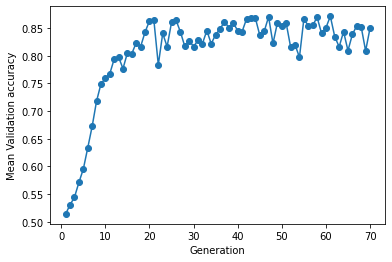

In [0]:
from matplotlib import pyplot as plt
y_axis = [0.5141500100493431, 0.5307300075888634, 0.5444000050425529, 0.5710100054740905, 0.5951100081205368, 0.6333000048995018, 0.672129999101162, 0.7178399994969368, 0.7490000054240227, 0.7591100037097931, 0.7672300040721893, 0.7940399959683418, 0.7972699970006942, 0.7767199963331223, 0.8051899999380112, 0.8037599980831146, 0.8236499965190888, 0.8165300011634826, 0.8427300006151199, 0.8627900034189224, 0.8636900007724762, 0.7835800066590309, 0.8401700019836426, 0.8163400024175644, 0.8603000044822693, 0.8645200043916702, 0.8433200031518936, 0.8169800013303756, 0.8271000057458877, 0.8165300041437149, 0.8278200060129166, 0.8216900020837784, 0.8452900022268295, 0.8215400010347367, 0.8382600009441376, 0.8481300055980683, 0.8616000026464462, 0.8506099998950958, 0.859009999036789, 0.8453099995851516, 0.8436600029468536, 0.8662800043821335, 0.8689399987459183, 0.8680600047111511, 0.8371700018644332, 0.8437400043010712, 0.8701700001955033, 0.8220499992370606, 0.8594099968671799, 0.854339998960495, 0.8584599971771241, 0.8154699981212616, 0.8196899980306626, 0.7971799939870834, 0.866349995136261, 0.8542199999094009, 0.8546099960803986, 0.8695299983024597, 0.84064000248909, 0.8503999978303909, 0.8712600022554398, 0.8343700021505356, 0.8160800039768219, 0.8434200048446655, 0.8092400029301643, 0.8384300023317337, 0.8541700005531311, 0.8519199967384339, 0.8086800023913383, 0.8498000025749206]
x_axis = [i for i in range(1,71)]
plt.plot(x_axis,y_axis,'-o')
plt.xlabel('Generation')
plt.ylabel('Mean Validation accuracy')

In [0]:
print([each.fitness for each in population])

[0.6534000039100647, 0.5184000134468079, 0.5062000155448914, 0.5217999815940857, 0.5062000155448914, 0.5126000046730042, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [0]:
geneticStuffs.max_generations

70

Just experiment. Genetic ends above